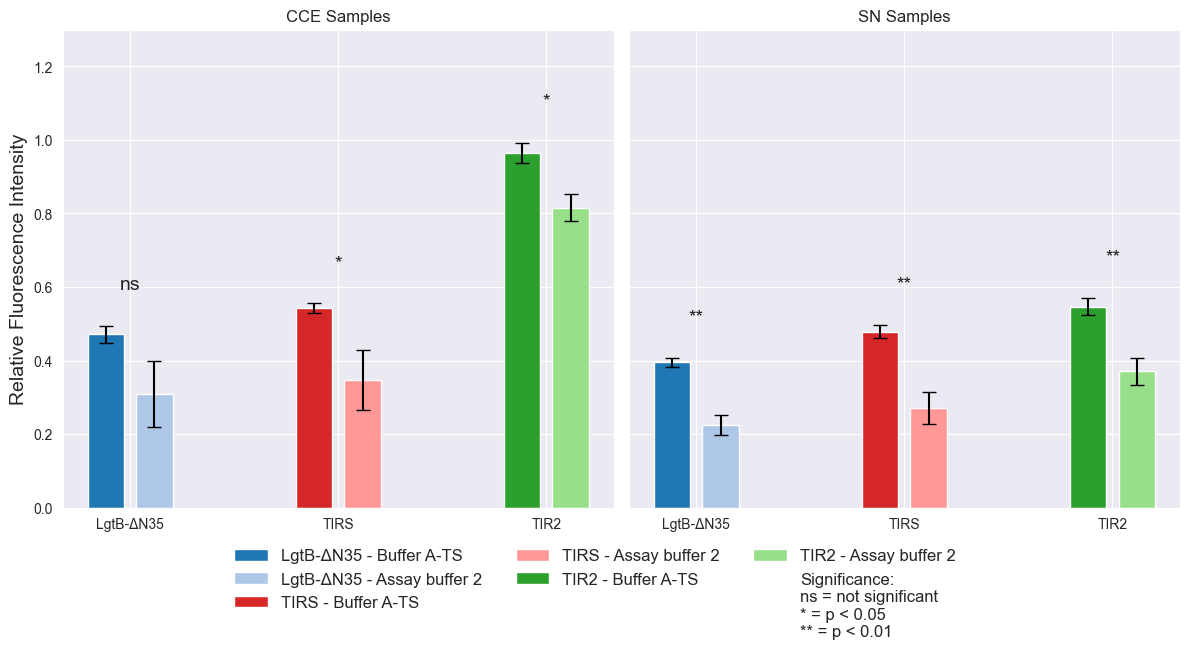

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from scipy.stats import ttest_ind

# File path
file_path = r'C:\Users\Lenovo\Documents\BT Studies\MASTER PROJECT\Tecan_intensities.xlsx'

# Load only columns 1 to 4
df = pd.read_excel(file_path, header=None, usecols=[0, 1, 2, 3])

# Parse data: 6 measurements (3 per group)
measurements = []
for i in range(0, 18, 3):
    enzymes = df.iloc[i, 1:].values
    cce_values = df.iloc[i+1, 1:].astype(float).values
    sn_values = df.iloc[i+2, 1:].astype(float).values
    measurements.append({'CCE': cce_values, 'SN': sn_values})

# Define groups
groups = {
    'Buffer A-TS': measurements[0:3],
    'Assay buffer 2': measurements[3:6]
}

# Calculate stats
group_stats = {'CCE': {}, 'SN': {}}
for sample_type in ['CCE', 'SN']:
    for group_name, group_data in groups.items():
        values = np.array([entry[sample_type] for entry in group_data])
        group_stats[sample_type][group_name] = {
            'mean': values.mean(axis=0),
            'std': values.std(axis=0),
            'all': values
        }

# Normalize
all_vals = np.concatenate([
    group_stats[sample][group]['all'].flatten()
    for sample in group_stats
    for group in group_stats[sample]
])
max_val = all_vals.max()

# Labels and positions
labels = ['LgtB-ΔN35', 'TIRS', 'TIR2']
x = np.arange(len(labels))
width = 0.35

# Color scheme: (dark, light)
enzyme_colors = {
    'LgtB-ΔN35': ('#1f77b4', '#aec7e8'),
    'TIRS': ('#d62728', '#ff9896'),
    'TIR2': ('#2ca02c', '#98df8a')
}

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
sample_types = ['CCE', 'SN']

for ax_idx, sample_type in enumerate(sample_types):
    ax = axes[ax_idx]

    for enzyme_idx, enzyme in enumerate(labels):
        for group_idx, group_name in enumerate(groups):
            stats = group_stats[sample_type][group_name]
            mean_val = stats['mean'][enzyme_idx] / max_val
            std_val = stats['std'][enzyme_idx] / max_val
            color = enzyme_colors[enzyme][group_idx]
            bar_x = enzyme_idx + (group_idx - 0.5) * (width / 1.5)

            ax.bar(bar_x, mean_val, yerr=std_val, width=width/2, color=color, capsize=5)

        # T-test
        vals1 = group_stats[sample_type]['Buffer A-TS']['all'][:, enzyme_idx]
        vals2 = group_stats[sample_type]['Assay buffer 2']['all'][:, enzyme_idx]
        stat, pval = ttest_ind(vals1, vals2)

        # Significance notation
        if pval < 0.01:
            sig = '**'
        elif pval < 0.05:
            sig = '*'
        else:
            sig = 'ns'

        # Plot significance text
        y_max = max(vals1.max(), vals2.max()) / max_val + 0.08
        x_center = enzyme_idx
        ax.text(x_center, y_max, sig, ha='center', va='bottom', fontsize=14)

    ax.set_title(f'{sample_type} Samples')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    if ax_idx == 0:
        ax.set_ylabel('Relative Fluorescence Intensity', fontsize=14)
    ax.set_ylim(0, 1.3)

# Legend: enzyme-buffer and significance
legend_elements = [
    Patch(facecolor=enzyme_colors['LgtB-ΔN35'][0], label='LgtB-ΔN35 - Buffer A-TS'),
    Patch(facecolor=enzyme_colors['LgtB-ΔN35'][1], label='LgtB-ΔN35 - Assay buffer 2'),
    Patch(facecolor=enzyme_colors['TIRS'][0], label='TIRS - Buffer A-TS'),
    Patch(facecolor=enzyme_colors['TIRS'][1], label='TIRS - Assay buffer 2'),
    Patch(facecolor=enzyme_colors['TIR2'][0], label='TIR2 - Buffer A-TS'),
    Patch(facecolor=enzyme_colors['TIR2'][1], label='TIR2 - Assay buffer 2'),
    Patch(facecolor='white', label='Significance:\nns = not significant\n* = p < 0.05\n** = p < 0.01')
]

fig.legend(handles=legend_elements, loc='lower center', ncol=3, frameon=False, bbox_to_anchor=(0.5, -0.1), fontsize=12)
plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()